In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import cfgrib
import json


import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def mask_cptye_with_gfs(path_2_credit, path_2_gfs):
    '''
    
    Function to mask credit ptype predictions  with gfs
    
    '''

    # load credit
    credit = xr.open_dataset(path_2_credit)
    
    gfs = xr.open_dataset(
        path_2_gfs,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )
    # create a no_precip class for gfs 
    gfs['no_precip'] = (
            (gfs['crain'] == 0) & 
            (gfs['csnow'] == 0) & 
            (gfs['cfrzr'] == 0) & 
            (gfs['cicep'] == 0)
        )
    # interpolate to match credit grid
    no_precip_numeric = gfs['no_precip'].astype(int)
    gfs_regridded = no_precip_numeric.interp(
        latitude=credit.isel(time=0).variables['latitude'].copy(), 
        longitude=credit.isel(time=0).variables['longitude'].copy(), 
        method='nearest'
    )
    gfs_regridded = gfs_regridded.astype(bool)

 
    credit_masked = credit.where(~gfs_regridded)
    return credit_masked

In [3]:

# 1 DAY LEAD TIME
# path1 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
# path2 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
# path3 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
# path4 = '/glade/work/sakor/gfs/gfs.0p25.2021021318.f000.grib2'

# 2 days lead time
path1 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-11T00Z/pred_2021-02-11T00Z_048.nc'
path2 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2021-02-11T00Z/pred_2021-02-11T00Z_048.nc'
path3 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-11T00Z/pred_2021-02-11T00Z_048.nc'
path4 = '/glade/work/sakor/gfs/gfs.0p25.2021021318.f000.grib2'

In [4]:
wx_6h= mask_cptye_with_gfs(path1,path4)
fuxi_6h =  mask_cptye_with_gfs(path2,path4)
wx_1h =mask_cptye_with_gfs(path3,path4)

In [5]:
def regrid_to_credit(path_2_credit, path_2_gfs):
    '''
    
    Function to mask credit ptype predictions  with gfs
    
    '''

    # load credit
    credit = xr.open_dataset(path_2_credit)
    
    gfs = xr.open_dataset(
        path_2_gfs,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )
   
    gfs_regridded = gfs.interp(
        latitude=credit.isel(time=0).variables['latitude'].copy(), 
        longitude=credit.isel(time=0).variables['longitude'].copy(), 
        method='nearest'
    ) 
    
    return gfs_regridded



In [6]:
gfs_regridded = regrid_to_credit(path3,path4)

In [7]:
def subset_by_extent(ds, extent):
    """
    Subset an xarray Dataset using geographic coordinates.
    
    Parameters:
        ds: xarray Dataset
        extent: [lon_min, lon_max, lat_min, lat_max]
    
    Returns:
        Subsetted xarray Dataset
    """
    lon_min, lon_max, lat_min, lat_max = extent
    
    # Handle longitude wrapping if needed (for 0-360 vs -180-180 data)
    if (ds.longitude.max() > 180) and (lon_min < 0):
        lon_min += 360
        lon_max += 360
    
    # Subset the data
    subset = ds.sel(
        longitude=slice(lon_min, lon_max),
        latitude=slice(lat_max, lat_min)  # Note: reverse order for latitude
    )
    
    return subset.assign_coords(longitude=((subset.longitude + 180) % 360) - 180)

In [8]:
extent = [-120, -75, 26, 50]

gfs_regridded = subset_by_extent(gfs_regridded, extent)

In [9]:
def classes(gfs_regridded):
    # Initialize with NaN (no precipitation)
    precip_type = xr.full_like(gfs_regridded['crain'], np.nan, dtype=np.float32)
    
    # Set values based on precipitation flags (order matters for priority!)
    precip_type = xr.where(gfs_regridded['crain'] == 1, 1, precip_type)    # 1 = rain
    precip_type = xr.where(gfs_regridded['csnow'] == 1, 2, precip_type)    # 2 = snow
    precip_type = xr.where(gfs_regridded['cfrzr'] == 1, 3, precip_type)   # 3 = freezing rain
    precip_type = xr.where(gfs_regridded['cicep'] == 1, 4, precip_type)   # 4 = ice pellets
    
    # Create the Dataset with proper attributes
    gfs_labels = xr.Dataset()
    gfs_labels['precip_type'] = precip_type.assign_attrs({
        'long_name': 'Precipitation type',
        'units': 'category',
        'flag_values': [1, 2, 3, 4],
        'flag_meanings': 'rain snow freezing_rain ice_pellets',
        'description': 'NaN = no precipitation'
    })
    
    # Optionally keep the original flags
    for var in ['crain', 'csnow', 'cfrzr', 'cicep']:
        gfs_labels[f'{var}_flag'] = gfs_regridded[var] == 1
    return gfs_labels['precip_type'].values.flatten()


def classes2(gfs_regridded):
    # Initialize with NaN (no precipitation)
    precip_type = xr.full_like(gfs_regridded['ML_crain'], np.nan, dtype=np.float32)
    
    # Set values based on precipitation flags (order matters for priority!)
    precip_type = xr.where(gfs_regridded['ML_crain'] == 1, 1, precip_type)    # 1 = rain
    precip_type = xr.where(gfs_regridded['ML_csnow'] == 1, 2, precip_type)    # 2 = snow
    precip_type = xr.where(gfs_regridded['ML_cfrzr'] == 1, 3, precip_type)   # 3 = freezing rain
    precip_type = xr.where(gfs_regridded['ML_cicep'] == 1, 4, precip_type)   # 4 = ice pellets
    
    # Create the Dataset with proper attributes
    gfs_labels = xr.Dataset()
    gfs_labels['precip_type'] = precip_type.assign_attrs({
        'long_name': 'Precipitation type',
        'units': 'category',
        'flag_values': [1, 2, 3, 4],
        'flag_meanings': 'rain snow freezing_rain ice_pellets',
        'description': 'NaN = no precipitation'
    })
    
    # Optionally keep the original flags
    for var in ['ML_crain', 'ML_csnow', 'ML_cfrzr', 'ML_cicep']:
        gfs_labels[f'{var}_flag'] = gfs_regridded[var] == 1
    return gfs_labels['precip_type'].values.flatten()

In [10]:
gfs = classes(gfs_regridded)

In [11]:
fuxi_6h = subset_by_extent(fuxi_6h,extent)
wx_6h = subset_by_extent(wx_6h,extent)
wx_1h = subset_by_extent(wx_1h,extent)

In [12]:
fuxi_6h = classes2(fuxi_6h)
wx_6h =  classes2(wx_6h)
wx_1h =  classes2(wx_1h)

In [13]:
gfs = gfs[~np.isnan(gfs)]
wx_6h = wx_6h[~np.isnan(wx_6h)]
wx_1h = wx_1h[~np.isnan(wx_1h)]
fuxi_6h = fuxi_6h[~np.isnan(fuxi_6h)]

In [14]:
len(wx_1h), len(wx_6h), len(fuxi_6h)

(4219, 4219, 4219)

## One day analysis

In [15]:
classes = [1, 2, 3, 4]
class_names = ['Ra', 'Sn', 'FrzRr', 'IceP']

In [16]:
cm_wx_6h = confusion_matrix(gfs, wx_6h, labels=classes, normalize='true')
cm_wx_1h = confusion_matrix(gfs, wx_1h, labels=classes, normalize='true')
cm_fuxi_6h = confusion_matrix(gfs, fuxi_6h, labels=classes, normalize='true')

In [17]:
np.sum(fuxi_6h ==2)/np.sum(gfs ==2)

0.9923518164435946

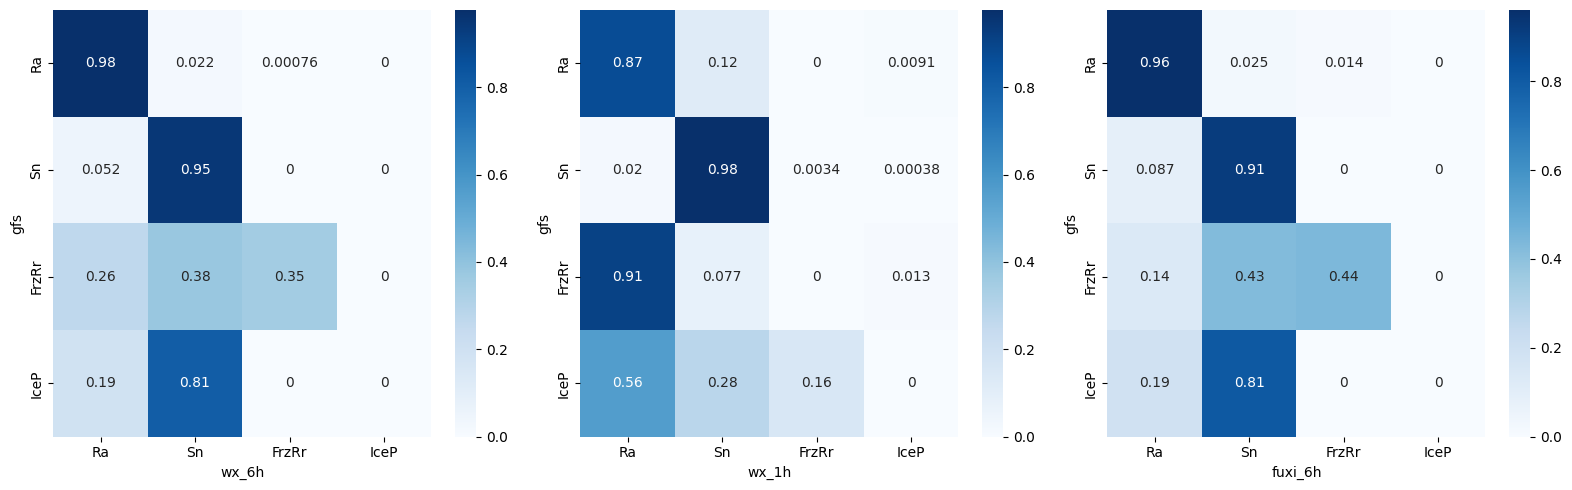

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))


sns.heatmap(cm_wx_6h, annot=True, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('wx_6h')
ax1.set_ylabel('gfs')


sns.heatmap(cm_wx_1h, annot=True, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)

ax2.set_xlabel('wx_1h')
ax2.set_ylabel('gfs')

sns.heatmap(cm_fuxi_6h, annot=True, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax3)
ax3.set_xlabel('fuxi_6h')
ax3.set_ylabel('gfs')

plt.tight_layout()
plt.savefig('a.pdf')
plt.show()


### Entire storm duration

In [19]:
wxformer_6h_dic = {}
wxformer_6h_dic['t1'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
wxformer_6h_dic['t2'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
wxformer_6h_dic['t3'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_024.nc'
wxformer_6h_dic['t4'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_030.nc'
wxformer_6h_dic['t5'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_036.nc'
wxformer_6h_dic['t6'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_042.nc'
wxformer_6h_dic['t7'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/ pred_2021-02-13T00Z_048.nc'


In [20]:
wxformer_1h_dic = {}
wxformer_1h_dic['t1'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
wxformer_1h_dic['t2'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
wxformer_1h_dic['t3'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_024.nc'
wxformer_1h_dic['t4'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_030.nc'
wxformer_1h_dic['t5'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_036.nc'
wxformer_1h_dic['t6'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_042.nc'
wxformer_1h_dic['t7'] = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/ pred_2021-02-13T00Z_048.nc'


In [21]:
gfs_dic = {}

In [22]:
# fuxi_6h_dic = {}
# fuxi_6h_dic['t1'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
# fuxi_6h_dic['t2'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_018.nc'
# fuxi_6h_dic['t3'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_024.nc'
# fuxi_6h_dic['t4'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_030.nc'
# fuxi_6h_dic['t5'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_036.nc'
# fuxi_6h_dic['t6'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_042.nc'
# fuxi_6h_dic['t7'] = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/ pred_2021-02-13T00Z_048.nc'


In [23]:
# wx_6h_dic = {}
# for key, value in wxformer_1h_dic.items():
#     print(key,value)
#     wx_6h_dic[key] = 